# Configuration Interaction (CI) to improve on Hartree-Fock

Slater determinant for $H_2$ in CI:

$
\begin{equation}
\ket{\Psi_{CI}} = c_0\ket{\Psi_0} + \sum_{i, a} c_i^a\ket{\Psi_i^a} + \sum_{i<j, a<b} c_{ij}^{ab}\ket{\Psi_{ij}^{ab}}
\end{equation}
$

In [1]:
# Required imports
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from basistool import compute_integrals
from tqdm.notebook import tqdm

In [ ]:
# Integrals
margin = 2.0
dists = np.geomspace(0.7, 8.0, 40)
datas = []
for dist in tqdm(dists):
    zgrid = np.arange(-dist / 2 - margin, dist / 2 + margin, 0.02)
    points = np.zeros((len(zgrid), 3))
    points[:, 2] = zgrid
    data = compute_integrals(
        ["H", "H"], [[0.0, 0.0, -dist / 2], [0.0, 0.0, dist / 2]], "basis_sets/aug-cc-pvtz.gbs", points
    )
    datas.append(data)

  0%|          | 0/40 [00:00<?, ?it/s]

In [119]:
def solve_rhf():
    for dist, data in zip(tqdm(dists), datas, strict=False):
        # Get a few operators.
        coreham = data["kei"] + data["nai"]
        eri = data["eri"]
        olp = data["oi"]
        data["hcore"] = coreham

        # The initial guess.
        eigvals, eigvecs = sp.linalg.eigh(coreham, olp)
        dm = np.dot(eigvecs[:, :1], eigvecs[:, :1].T)  # RHF (1 alpha, 1 beta)

        # The scf cycle (See 02_helium.ipynb for details.)
        for _scf_counter in range(500):
            hartree = np.einsum("kmln,nm->kl", eri, dm)
            exchange = np.einsum("kmnl,nm->kl", eri, dm)
            fock = coreham + 2 * hartree - exchange  # Specific for RHF

            errors_rh = np.dot(fock, eigvecs) - np.einsum("ij,jk,k->ik", olp, eigvecs, eigvals)
            error_rh = np.linalg.norm(errors_rh)  # Frobenius norm
            if error_rh < 1e-7:
                break

            eigvals, eigvecs = sp.linalg.eigh(fock, olp)
            dm = np.dot(eigvecs[:, :1], eigvecs[:, :1].T)
        else:
            raise RuntimeError("SCF convergence failed")

        # Compute the _electronic_ energy.
        ham = coreham + hartree - 0.5 * exchange  #  RHF
        electronic_energy = 2 * np.einsum("ij,ji", ham, dm)  # RHF

        # Compute the occupied orbital on the grid.
        psi0 = np.dot(eigvecs[:, 0], data["bfs"])  # RHF occupied orbital (ground state, thus 0)

        # Store results back into the data dictionary.
        # (Mind the two electrons.)
        data["eigvecs_rhf"] = eigvecs
        data["eigvals_rhf"] = eigvals
        data["energy_rhf"] = electronic_energy + 1 / dist
        data["density_rhf"] = 2 * psi0**2  # RHF


solve_rhf()

  0%|          | 0/40 [00:00<?, ?it/s]

In [173]:
def solve_ufh():
    for dist, data in zip(tqdm(dists), datas, strict=False):
        # Get a few operators.
        coreham = data["kei"] + data["nai"]
        eri = data["eri"]
        olp = data["oi"]

        # The initial guess.
        eigvals, eigvecs = sp.linalg.eigh(coreham, olp)
        dm = np.dot(eigvecs[:, :2], eigvecs[:, :2].T)  # UHF (2 alphas)

        # The SCF cycle (See 02_helium.ipynb for details.)
        for _scf_counter in range(500):
            hartree = np.einsum("kmln,nm->kl", eri, dm)
            exchange = np.einsum("kmnl,nm->kl", eri, dm)
            fock = coreham + hartree - exchange  # UHF

            errors_rh = np.dot(fock, eigvecs) - np.einsum("ij,jk,k->ik", olp, eigvecs, eigvals)
            error_rh = np.linalg.norm(errors_rh)  # Frobenius norm
            if error_rh < 1e-7:
                break

            eigvals, eigvecs = sp.linalg.eigh(fock, olp)
            dm = np.dot(eigvecs[:, :2], eigvecs[:, :2].T)
        else:
            raise RuntimeError("SCF convergence failed")

        # Compute the _electronic_ energy.
        ham = coreham + 0.5 * hartree - 0.5 * exchange  # UHF
        electronic_energy = np.einsum("ij,ji", ham, dm)  # UHF

        # Compute the occupied orbitals on the grid.
        psi0 = np.dot(eigvecs[:, 0], data["bfs"])  # UHF
        psi1 = np.dot(eigvecs[:, 1], data["bfs"])  # UHF
        
        # Store the energy. The second term in the energy is the nucleus-nucleus
        # repulsion.
        data["eigvecs_uhf"] = eigvecs
        data["eigvals_uhf"] = eigvals
        data["energy_uhf"] = electronic_energy + 1 / dist
        data["density_uhf"] = psi0**2 + psi1**2
        data["density0_uhf"] = psi0**2
        data["density1_uhf"] = psi1**2


solve_ufh()

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
def ao_to_mo_2orb(data, rfh=True):
    """
    Function to change between the basis consisting of basis functions (b_i) and the basis consisting
    of molecular orbitals (MO). We only keep the 2 MO with lowest energies, corresponding to the two
    sigma orbitals
    ----------
    Parameters
    ----------
    data : dict
        Dictionary containing the data we need (integrals, basis functions, ...)
    rfh : bool
        Boolean value that is True if we look at CI using RHF. If False, calculations are based on UHF.
    ----------
    returns
        h, g : np.array, np.aray
            h is the core Hamiltonian H_kl = T_kl + V_ext_kl
            g is the electron repulsion integral V_ee_ijkl
    """
    if rfh: 
        C = data["eigvecs_rhf"][:, :2]   # keep 2 lowest MOs (18,2) (bonding and antibonding MO)
    else:
        C = data["eigvecs_uhf"][:, :2]   # keep 2 lowest MOs (18,2) (bonding and antibonding MO)

    h_ao = data["hcore"] #(18,18)
    eri_ao = data["eri"]  
    h = C.T @ h_ao @ C #(2,2) = (2,18) * (18,18) * (18,2), core hamiltonian
    g = np.einsum("pqrs,pi,qj,rk,sl->ijkl", eri_ao, C, C, C, C, optimize=True) #eri_MO (2,2,2,2) because only 2 lowest MO
    return h, g

def ci_block_singlet_2orb(h, g):
    """
    Function to perform the CI calculations using the core hamiltonian and electron repulsion integral
    of the ao_to_mo_2orb function. It returns the Hamiltonian to be diagonalized in the Molecular orbital
    basis. The columns consist of the ground state Slater Determinant, the SD with 1 excited electron and
    the SD with 2 excited electrons.
    ----------
    Parameters
    ----------
    h : np.array
        numpy array containing the values for the core hamiltonian H_kl
    g : np.array
        numpy array containing the values for the electron repulsion integral V_ee_ijkl 
    ----------
    returns
        The full Hamiltonian H of the CI system, in the MO basis.
    """
    #h is one body operator in MO basis
    h00, h11 = h[0,0], h[1,1]
    h01 = h[0,1]

    #g is two body operator in MO basis
    g0000 = g[0,0,0,0]
    g1111 = g[1,1,1,1]
    g0011 = g[0,0,1,1]
    g0110 = g[0,1,1,0]
    g0101 = g[0,1,0,1]
    g0001 = g[0,0,0,1]
    g0111 = g[0,1,1,1]

    H = np.zeros((3,3))
    # Diagonals (0=00, 1=01, 2=11)
    H[0,0] = 2*h00 + g0000 #reference-reference (2e in GS, so 2*h00 + hartree (Hartree J and no exchange))
    H[1,1] = h00 + h11 + g0101 #single-single (1e in GS + 1e is excited + Hartree (no exchange because opposite spin because singlet))
    H[2,2] = 2*h11 + g1111 #double-double (2e excited + Hartree J)
    # Off-diagonals
    H[0,1] = H[1,0] = np.sqrt(2) * (h01 + g0001) #reference-single
    H[1,2] = H[2,1] = np.sqrt(2) * (h01 + g0111) #single-double
    H[0,2] = H[2,0] =  g0011 #reference-double
    return H

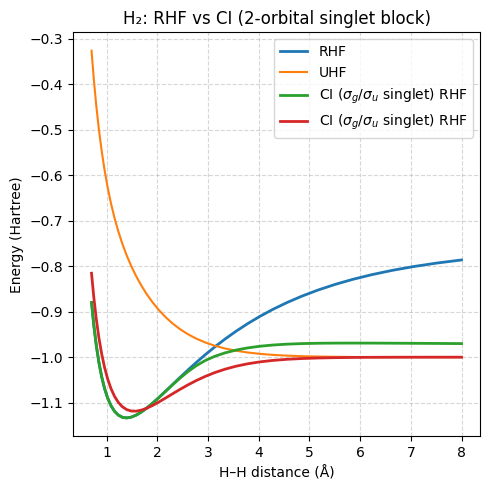

In [191]:
E_rhf = []
E_uhf = []
E_ci_rhf  = []
E_ci_uhf  = []

eigvecs_rhf = []
eigvecs_uhf = []

for R, data in zip(dists, datas, strict=False):
    # RHF total energy was stored as energy_rhf (already includes nuclear repulsion)
    E_rhf.append(data["energy_rhf"])
    E_uhf.append(data["energy_uhf"])

    # CI (3×3 singlet block)
    h_rhf, g_rhf = ao_to_mo_2orb(data)
    h_uhf, g_uhf = ao_to_mo_2orb(data, False)

    H_rhf = ci_block_singlet_2orb(h_rhf, g_rhf)
    H_uhf = ci_block_singlet_2orb(h_uhf, g_uhf)

    eigvals_rhf, eigvec_rhf = np.linalg.eigh(H_rhf)
    eigvals_uhf, eigvec_uhf = np.linalg.eigh(H_uhf)

    E_ci_rhf.append(eigvals_rhf[0] + 1.0 / R)  # add nuclear repulsion
    E_ci_uhf.append(eigvals_uhf[0] + 1.0 / R)  # add nuclear repulsion

    eigvecs_rhf.append(eigvec_rhf)
    eigvecs_uhf.append(eigvec_uhf)

E_rhf = np.array(E_rhf)
E_ci_rhf  = np.array(E_ci_rhf)
E_ci_uhf  = np.array(E_ci_uhf)
eigvecs_rhf  = np.array(eigvecs_rhf)
eigvecs_uhf  = np.array(eigvecs_uhf)

def plot_CI_energies():
    # --- Plot ---
    plt.figure(figsize=(5,5))
    plt.plot(dists, E_rhf, label="RHF", lw=2)
    plt.plot(dists, E_uhf, label="UHF")
    plt.plot(dists, E_ci_rhf,  label=r"CI ($\sigma_g/\sigma_u$ singlet) RHF", lw=2)
    plt.plot(dists, E_ci_uhf,  label=r"CI ($\sigma_g/\sigma_u$ singlet) RHF", lw=2)
    plt.xlabel("H–H distance (Å)")
    plt.ylabel("Energy (Hartree)")
    plt.title("H₂: RHF vs CI (2-orbital singlet block)")
    plt.legend()
    plt.grid(True, ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("rhf_vs_ci.png", dpi=200)
    plt.show()

plot_CI_energies()

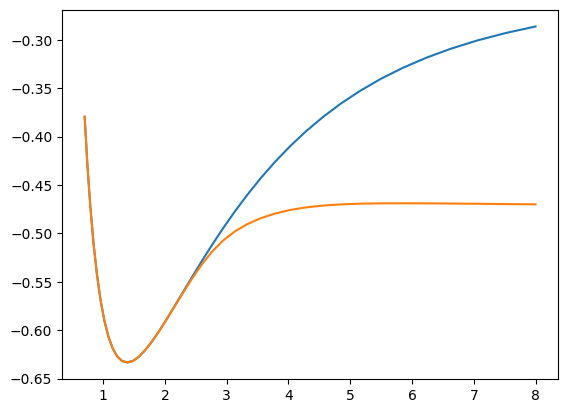

In [166]:
hartree = 27.211386245981 #eV
H_atom = -13.6 #eV
H_atom_hartree = H_atom/hartree

diff_rhf_2H = E_rhf - H_atom_hartree
diff_ci_rhf_2H = E_ci_rhf - H_atom_hartree

plt.plot(dists, diff_rhf_2H)
plt.plot(dists, diff_ci_rhf_2H)
plt.show()

In [263]:
idx = 3  # choose geometry index explicitly
print("Using R =", dists[idx])

data_i = datas[idx]
C = data_i["eigvecs_rhf"][:, :2]

c0_rhf, c1_rhf, c2_rhf = eigvecs_rhf[idx, :, 0]
c0_uhf, c1_uhf, c2_uhf = eigvecs_uhf[idx, :, 0]

# 1-particle density matrix in MO basis
gamma_mo_rhf = np.array([[2*c0_rhf**2 + c1_rhf**2, np.sqrt(2)*(c0_rhf*c1_rhf + c1_rhf*c2_rhf)],
                     [np.sqrt(2)*(c0_rhf*c1_rhf + c1_rhf*c2_rhf), 2*c2_rhf**2 + c1_rhf**2]])
gamma_mo_uhf = np.array([[2*c0_uhf**2 + c1_uhf**2, np.sqrt(2)*(c0_uhf*c1_uhf + c1_uhf*c2_uhf)],
                     [np.sqrt(2)*(c0_uhf*c1_uhf + c1_uhf*c2_uhf), 2*c2_uhf**2 + c1_uhf**2]])

# Transform to AO basis
gamma_ao_rhf = C @ gamma_mo_rhf @ C.T
gamma_ao_uhf = C @ gamma_mo_uhf @ C.T

# Compute density along points (assume 'ao_vals' is AO basis evaluated on grid)
density_rhf_ci = np.einsum("pq,pi,qi->i", gamma_ao_rhf, data_i["bfs"], data_i["bfs"])
density_uhf_ci = np.einsum("pq,pi,qi->i", gamma_ao_uhf, data_i["bfs"], data_i["bfs"])

Using R = 0.8442713189278581


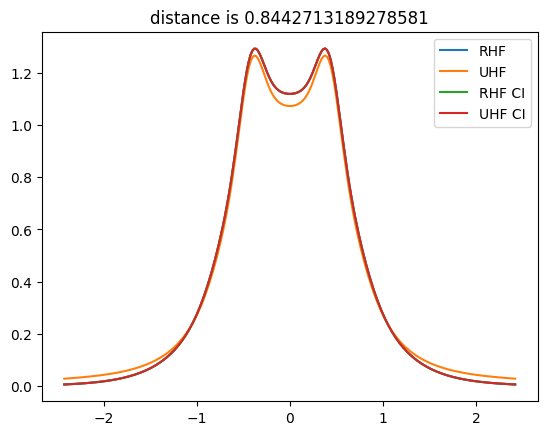

In [264]:
def normalize_density_1d(z, rho, Nelec=2.0):
    norm = np.trapz(rho, z)
    return rho * (Nelec / norm)

z = data_i["points"][:, 2]
density_rhf_ci = normalize_density_1d(z, density_rhf_ci, Nelec=2.0)
density_uhf_ci = normalize_density_1d(z, density_uhf_ci, Nelec=2.0)
density_rhf = normalize_density_1d(z, data_i["density_rhf"], Nelec=2.0)
density_uhf = normalize_density_1d(z, data_i["density_uhf"], Nelec=2.0)

plt.title(f"distance is {dists[idx]}")
plt.plot(data_i["points"][:, 2], density_rhf, label="RHF")
plt.plot(data_i["points"][:, 2], density_uhf, label="UHF")
plt.plot(data_i["points"][:, 2], density_rhf_ci, label="RHF CI")
plt.plot(data_i["points"][:, 2], density_uhf_ci, label="UHF CI")
plt.legend()
plt.show()